In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import numpy as np
import anndata as ad
from tqdm import tqdm

# from jax.config import config
# config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/DataUpload")
path_write = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

In [4]:
def check_write(dataset: str):
    dataset_read = dataset
    dataset_write = dataset_read.lower()

    # sc_count = pd.read_csv(
    #     path_read / dataset_read / "scRNA_count.txt", sep="\t", header=0, index_col=0
    # ).T

    spatial_count = pd.read_csv(
        path_read / dataset_read / "Spatial_count.txt", sep="\t"
    )

    # insitu_count = pd.read_csv(path_read / dataset_read / "Insitu_count.txt", sep="\t")

    #     test_list = np.load(path_read / dataset_read / "test_list.npy", allow_pickle=True)
    #     train_list = np.load(path_read / dataset_read / "train_list.npy", allow_pickle=True)

    #     adata_sc = AnnData(csr_matrix(sc_count.to_numpy()), dtype=sc_count.to_numpy().dtype)
    #     adata_sc.var_names = sc_count.columns.tolist()

    adata_sp = AnnData(
        csr_matrix(spatial_count.to_numpy()), dtype=spatial_count.to_numpy().dtype
    )
    adata_sp.var_names = spatial_count.columns.tolist()

    # adata_insitu = AnnData(
    #     csr_matrix(insitu_count.to_numpy()), dtype=insitu_count.to_numpy().dtype
    # )
    # adata_insitu.var_names = insitu_count.columns.tolist()

    # adata_sc = process_normalize(adata_sc)
    adata_sp = process_normalize(adata_sp)
    # adata_insitu = process_normalize(adata_insitu)

    try:
        # sc.pp.pca(adata_sc)
        sc.pp.pca(adata_sp)
        # sc.pp.pca(adata_insitu)
        locations = pd.read_csv(
            path_read / dataset_read / "Locations.txt",
            sep="\t",
        )
        adata_sp.obsm["spatial"] = locations.to_numpy()
        # adata_insitu.obsm["spatial"] = locations.to_numpy()
    except ValueError:
        return

    # adata_sc.write(path_write / f"{dataset_write}_sc.h5ad")
    adata_sp.write(path_write / f"{dataset_write}_sp.h5ad")
    # adata_insitu.write(path_write / f"{dataset_write}_insitu.h5ad")

    # del adata_sc
    del adata_sp
    # del adata_insitu
    # del sc_count
    del spatial_count
    # del insitu_count

    return


def process_normalize(adata: AnnData):
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_counts=2)
    adata.layers["counts"] = adata.X.copy()
    if adata.shape[1] > 5000:
        sc.pp.highly_variable_genes(
            adata, flavor="seurat_v3", n_top_genes=2000, subset=True
        )
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    return adata.copy()

In [5]:
dataset = "Dataset21"
check_write(dataset)

In [6]:
# os.listdir(path_read)[:3]

In [7]:
result = Parallel(n_jobs=6)(
    delayed(check_write)(dataset) for dataset in tqdm(os.listdir(path_read))
)

 13%|█▎        | 6/45 [00:00<00:05,  7.78it/s]/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
 40%|████      | 18/45 [00:30<00:56,  2.09s/it]/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
 53%|█████▎    | 24/45 [00:34<00:32,  1.56s/it]/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

### Check datasets
some datasets in the benchmark failed, probably due to wrong names/index

In [2]:
benchmark_datasets = [30, 37, 45, 26, 22, 33, 32, 14, 3, 20, 21, 41, 1, 39]
missed_dataset = [22, 3, 1, 30, 37, 45, 41, 39]

In [8]:
dataset = "dataset22"
# adata_sc = ad.read(path_write / f"{dataset.lower()}_sc.h5ad")
adata_sp = ad.read(path_write / f"{dataset.lower()}_sp.h5ad")

In [9]:
adata_sp.shape

(2432, 2000)

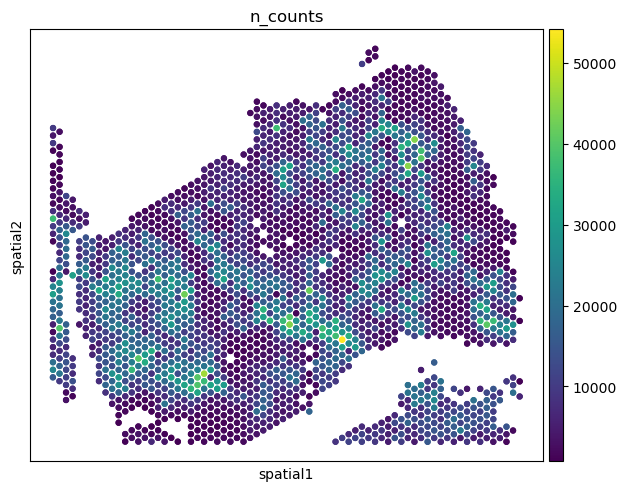

In [5]:
import squidpy as sq

sq.pl.spatial_scatter(adata_sp, color=["n_counts"], shape=None)

In [17]:
import os
dataset = os.listdir("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")
dataset
unique_id = [int(i.lstrip("dataset").replace("_sp.h5ad","")) for i in dataset]
print(unique_id)

[45, 7, 3, 20, 18, 34, 37, 26, 4, 1, 32, 30, 39, 22, 5, 24, 35, 14, 29, 19, 41, 36, 23, 43, 21, 42, 27, 17, 33, 2, 25, 10]
